Tutorial 1: Source Code
=======================

In chapter 1, all tutorials were self contained. The code used to define the model, analysis, run the NonLinearSearch,
load data and plot images were contained in the Jupyter notebooks of the tutorial itself. If you wanted to simply
parameterize and fit models quickly, chapter 1 taught us how to do that with **PyAutoFit**.

However, for a long-term software development project, the code would not be contained in one script but instead make
up the project's source code. In this chapter, we will set up the code for the 1D Gaussian fitting example as if it
were an actual software project with a clearly defined source code library. This source code can be found in the folder
`/autofit_workspace/howtofit/chapter_phase_api/src`.

This project will follow the same object-oriented design our Astronomy software packages that use **PyAutoFit** do:

  - PyAutoGalaxy: https://github.com/Jammy2211/PyAutoGalaxy
  - PyAutoLens: https://github.com/Jammy2211/PyAutoLens
  - PyAutoCTI: https://github.com/Jammy2211/PyAutoCTI

We believe our design is a good template for any model-fitting software and recommend that if you are using PyAutoFit
for a long-term software development project you aim to closely closely the design. In particular, the design:

 - Uses the **PyAutoFit** Phase API, which provides **PyAutoFit** with a more direct interface with the model, data
 and results as well as providing a concise API for users of the software.

 - Uses our parent project **PyAutoConf** to set up configuration files for managing many aspects of the model-fitting
software.

 - Follows an object oriented design that provides the best interface with **PyAutoFit** features like the `Aggregator`.

To begin, check out the `src` folder, noting the directory structure of the source code is separated into 5 packages:
`dataset`, `fit`, `model`, `plot` and `phase`. This separates the different parts of the code which perform
different tasks. For example, the code which handles model composition is separate from the code which handles model
fitting.

This ensures good code design by removing dependencies between parts of the code that do not need them! This is a
principle aspect of object oriented design and software engineering called `separation of concerns`, which the template
project strongly adheres too.

In [1]:
%matplotlib inline
from pyprojroot import here

workspace_path = str(here())
%cd $workspace_path
print(f"Working Directory has been set to `{workspace_path}`")

from os import path
import autofit as af

/mnt/c/Users/Jammy/Code/PyAuto/autofit_workspace
Working Directory has been set to `/mnt/c/Users/Jammy/Code/PyAuto/autofit_workspace`


We will describe this line of code in the next tutorial.

In [2]:
from autoconf import conf

conf.instance.push(
    new_path=path.join(workspace_path, "howtofit", "chapter_phase_api", "src", "config")
)

First, checkout the file 

 `autofit_workspace/howtofit/chapter_phase_api/src/__init__.py

Here, we have added imports to this file allowing us to import the entire project in one go, which we do below,
importing it as `htf`. 

Many software projects tend not to do this, instead relying on the user explicitly importing every module in the 
project that need, for example:

`from src.dataset.dataset import Dataset`

`from src.model.gaussian import Gaussian`

`from src.plot import dataset_plots`

`from src.plot import fit_plots`

Clearly, this creates a burden on the user, as they have to understand the project structure! Furthermore, as you'll 
see below, by controlling the project import in this way you can design an API that makes tasks like plotting results 
more intuitive.

In [3]:
import src as htf

To begin, in the `src` folder checkout the `dataset` package, which contains one module, `dataset.py`. Whereas the 
previous tutorial used arrays for the `data` and `noise_map`, from here on we'll combine them  into a `Dataset` class,  
which can be easily extended if our model-fitting problem has additional data components.

The `dataset.py` module contains a number of methods and classes that will be expanded upon in tutorial 3. These are
associated with trimming, Settings, etc.

To create the `Dataset`, we load it from the `autofit_workspace/dataset` folder and then create a `Dataset` object. 

In [4]:
dataset_path = path.join("dataset", "example_1d", "gaussian_x1")
data = af.util.numpy_array_from_json(file_path=path.join(dataset_path, "data.json"))
noise_map = af.util.numpy_array_from_json(
    file_path=path.join(dataset_path, "noise_map.json")
)
dataset = htf.Dataset(data=data, noise_map=noise_map)

Previously, we manually specified how to plot the `Dataset` using a `plot_line` method. These plotting functions are 
now in the source code, in the `plot` package, check them out now! You'll note we have separate modules for plotting 
lines corresponding to the `Dataset` or to a fit.

You should take note of two things:  

 - The `dataset_plots.py` plot functions take instances of the `Dataset` class, meaning we we don't have to manually 
 specify the part of our data we want to pass to the function, making for a more concise API.
 
 - In `plot/__init__.py` we have imported the `dataset_plots.py`, `fit_plots.py` and `line_plots.py` modules as their 
 corresponding class names; `Dataset`, `FitDataset` and `Line`. We'll see later how this provides a clean API, where 
 it is immediately obvious to the user how to plot the objects they have used elsewhere in the project for performing 
 calculations.

Lets use a plot function to plot our data.

In tutorial 4, we'll use this results to inspect the `Aggregator` more. We have setup the template project so the `info`
dictionary can again be used by the project.

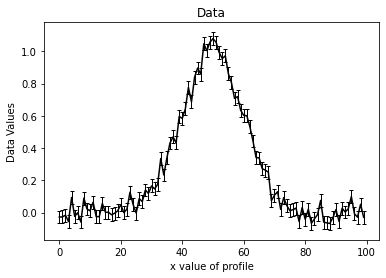

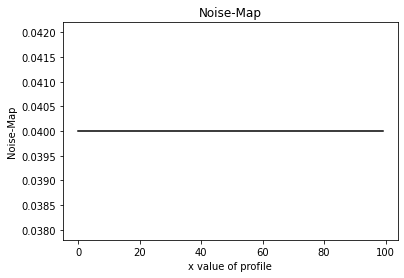

<Figure size 432x288 with 0 Axes>

In [5]:
info = {"date_of_observation": "01-02-18", "exposure_time": 1000.0}

htf.plot.Dataset.data(dataset=dataset)
htf.plot.Dataset.noise_map(dataset=dataset)

Next, look at the `model` package, which contains the module `profiles.py`. This contains the `Gaussian` and 
`Exponential` classes we have used previously to compose the 1D `Gaussian` model that we fit. They now use a class
inheritance structure.

By packaging all the model components into a single package, this will make it straight forward to add new model
components to the source code.

In [6]:
gaussian = htf.Gaussian(centre=50.0, intensity=2.0, sigma=20.0)

Next, lets checkout the `fit` package which contains the `fit.py` module. This packages fitting methods which compute
the quantities we introduced in chapter 1 (residual-map, chi_squareds, log likelihoods, etc.) into a single 
`FitDataset` class.

Again, take note of how the fit plot functions take an instance of the `FitDataset` class and were imported as 
`FitDataset`, making for a clean API where it is intuitive how to plot the fit.

Below, I used the `Gaussian` model above to illustrate how we can easily plot different aspects of a fit. 

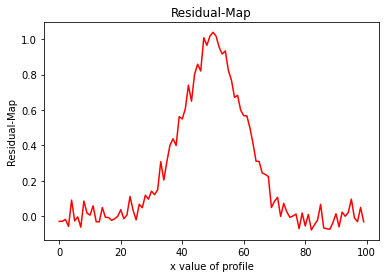

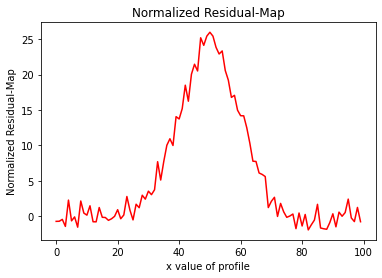

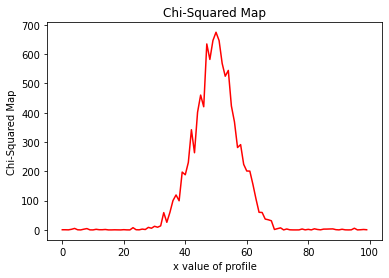

<Figure size 432x288 with 0 Axes>

In [7]:
model_data = gaussian.profile_from_xvalues(xvalues=dataset.xvalues)

fit = htf.FitDataset(dataset=dataset, model_data=model_data)

htf.plot.FitDataset.residual_map(fit=fit)
htf.plot.FitDataset.normalized_residual_map(fit=fit)
htf.plot.FitDataset.chi_squared_map(fit=fit)

As we discussed in chapter 1, the different steps of performing a fit (e.g. computing the residuals, the chi-squared,
log likelihood, and so forth) are pretty much generic tasks performed by any model-fitting problem. 

Thus, you should literally be able to copy and paste the `FitDataset` class found in this tutorial (and future 
tutorials) and use them in your modeling software! I have made sure the class works for datasets of higher 
dimensionality (e.g. 2D images or 3D datacubes).

For simplicitly, this example project does not include masking of data before a fit (e.g. to remove certain regions of 
the data during a fit). In tutorial 4 of this chapter we describe how one would extend this project to include the 
fitting of a masked data, including a `FitMaskedDataset` class which you should again be able to copy and paste for 
your software project.

We're finally ready to look at how our source code sets up the `NonLinearSearch` and model-fit. Whereas before we 
manually set up the `PriorModel`, `Analysis` and `NonLinearSearch`, from now on we're going to use **PyAutoFit**'s 
Phase API which uses the `phase` package, which contains 5 modules: `phase.py`, `analysis.py`, `result.py`, 
`visualizer.py` and `settings.py`.

At this point, you should open and inspect (in detail) the 3 source code files `phase.py`, `analysis.py` and 
`result.py` (we'll cover the other 2 in tutorials 2 and 3).

An over view of each is as follows:

`phase.py` -> contains the Phase class:

 - Receives the model to be fitted (in this case a single `Gaussian`..
 
 - Handles the directory structure of the output (in this example results are output to the folder
 `/output/phase_example/`.
 
  Is passed the data when run, which is set up for the analysis.

`analysis.py` -> contains the `Analysis` class (and is a restructred version of the the previous tutorial's 
  `Analysis` class):

 - Prepares the `Dataset` for fitting.
 
 - Fits this `Dataset` with a model instance to compute a `log_likelihood` for every iteration of the `NonLinearSearch`.

`result.py` -> contains the `Result` class:

 - Stores the `Samples` object containing information on the `NonLinearSearch`'s samples.
 
 - Has functions to create the `model-image`, `residual-map`, `chi_squared_map` and so forth of the 
 maximum log likelihood model etc.

Performing a `NonLinearSearch` in **PyAutoFit** now only requires that we instantiate and run a `Phase` object. The 
`Phase` performs the following tasks (which we performed manually in the previous tutorial):

 - Builds the model to be fitted and interfaces it with the `NonLinearSearch`.
 
 - Receives the data to be fitted and prepares it so the model can fit it.
 
 - Contains the `Analysis` class that defines the `log_likelihood_function`.
 
 - Returns the `Result`'s, including the `NonLinearSearch`'s `Samples`'s and the maximum likelihood fit.

Note that, like before, priors are loaded from the config file `autofit_workspace/config/priors/profiles.json`. 

Lets instantiate and run a phase, which reduces the task of performing a model-fit in **PyAutoFit** to just two lines
of code.  The results are output to the path `autofit_workspace/output/howtofit/chapter_phase_api/phase_t1`

In [8]:
phase = htf.Phase(
    search=af.Emcee(
        path_prefix="howtofit", name="tutorial_1_source_code",
    ),
    settings=htf.SettingsPhase(),  # We describe `Settings` objects in tutorial 3.
    profiles=af.CollectionPriorModel(gaussian=htf.Gaussian),
)

print(
    "Emcee has begun running, checkout: \n"
    "autofit_workspace/output/howtofit/chapter_phase_api/phase_t1 \n"
    "for live output of the results.\n"
    "This Jupyter notebook cell with progress once Emcee has completed - this could take a few minutes!"
)

result = phase.run(dataset=dataset, info=info)

print("Emcee has finished run - you may now continue the notebook.")

INFO:root:Generating initial samples of model, which are subject to prior limits and other constraints.
INFO:root:No Emcee samples found, beginning new non-linear search.
100%|██████████| 1/1 [00:00<00:00, 31.52it/s]
INFO:root:500 Iterations: Performing update (Visualization, outputting samples, etc.).
/home/jammy/venvs/PyAuto/lib/python3.8/site-packages/emcee/autocorr.py:36: RuntimeWarning: invalid value encountered in true_divide
  acf /= acf[0]
INFO:root:Emcee sampling complete.
INFO:root:1000 Iterations: Performing update (Visualization, outputting samples, etc.).


Emcee has begun running, checkout: 
autofit_workspace/output/howtofit/chapter_phase_api/phase_t1 
for live output of the results.
This Jupyter notebook cell with progress once Emcee has completed - this could take a few minutes!
output/howtofit/tutorial_1_source_code/settings__dataset[]/emcee[nwalkers_50]/samples/emcee.hdf
output/howtofit/tutorial_1_source_code/settings__dataset[]/emcee[nwalkers_50]/samples/emcee.hdf
Emcee has finished run - you may now continue the notebook.


<Figure size 432x288 with 0 Axes>

The phase returns a `Result` object, just like the model-fit performed in the previous tutorial did. However, in
`result.py` you'll have noted we extended the `Result` object to include a property containing an `instance` of the 
maximum likelihood fit in the form of a `FitDataset` object. 

This illustrates a benefit of containing the entire fit into one class, we can more easily return it to the user 
after a model-fit is performed.

In [9]:
print(result.max_log_likelihood_fit)

Another benefit of writing our `plot` functions so that their inputs are instances of the classes they plot is now 
clear. We can  visualize our `Result`'s by simply passing these methods the `FitDataset` instance which is readily 
available in the results to our `plot` functions!

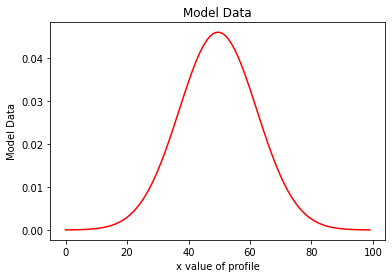

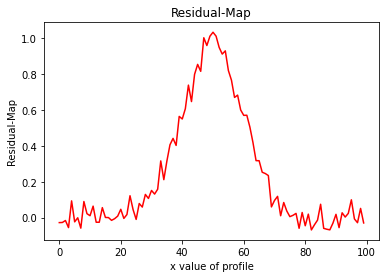

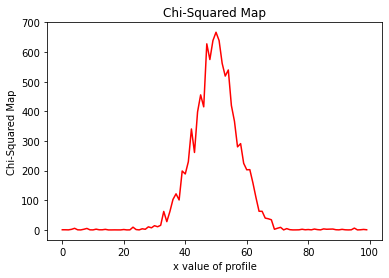

<Figure size 432x288 with 0 Axes>

In [10]:
htf.plot.FitDataset.model_data(fit=result.max_log_likelihood_fit)
htf.plot.FitDataset.residual_map(fit=result.max_log_likelihood_fit)
htf.plot.FitDataset.chi_squared_map(fit=result.max_log_likelihood_fit)

Making plots such as these in chapter 1 was cumbersome, and required us to write lots of specific Python code to do!

And with that, we have introduced the **PyAutoFit** phase API alongside an example project, which provides a template 
on how to structure model-fitting software. 

The remaining tutorials describe functionality included in this source code. At this point, you  should be thinking 
about how this structure mighr benefit your model-fitting software!